# Model predicting on crops

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, Path(".").absolute().parent.as_posix())

import numpy as np
from common.dataset import FilesFromCsvDataset, TrainvalFilesDataset, TransformedDataset, read_image, TestFilesDataset
from image_dataset_viz import render_datapoint, DatasetExporter

In [2]:
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
dataset = TrainvalFilesDataset("/home/fast_storage/imaterialist-challenge-furniture-2018/train/")
img_dataset = TransformedDataset(dataset, transforms=lambda x: read_image(x), target_transforms=lambda y: y - 1)

In [10]:
from torchvision.transforms import Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomResizedCrop
from torchvision.transforms import RandomApply, RandomChoice
from torchvision.transforms import ColorJitter, ToTensor, Normalize


size = 350
basic_train_augs = Compose([
    RandomChoice(
        [
            RandomResizedCrop(size, scale=(0.4, 0.6), interpolation=3),
            RandomResizedCrop(size, scale=(0.6, 1.0), interpolation=3),
        ]
    ),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    ColorJitter(hue=0.12, brightness=0.12),
#     ToTensor(),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

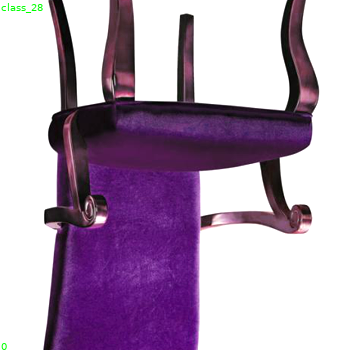

In [11]:
img_augs_dataset = TransformedDataset(img_dataset, transforms=basic_train_augs)

img, label = img_augs_dataset[12]
render_datapoint(img, "class_{}".format(label), image_id="0")

5 crops

In [6]:
# FiveCrop??

In [162]:
import torch
from torchvision.transforms import FiveCrop, Lambda, Resize


single_img_augs = Compose([
    RandomHorizontalFlip(p=0.5),
    ColorJitter(hue=0.12, brightness=0.12),
#     ToTensor(),
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

size = 350
augs_branch_1 = RandomResizedCrop(size, scale=(0.9, 1.0), interpolation=2)
augs_branch_2 = Compose([Resize(512, interpolation=2), FiveCrop(size=size)])


crops_train_augs = Compose([
    Lambda(lambda img: (augs_branch_1(img), ) + augs_branch_2(img)),
    Lambda(lambda crops: [single_img_augs(crop) for crop in crops])
#     Lambda(lambda crops: torch.stack([single_img_augs(crop) for crop in crops]))
])

In [165]:
img_augs_dataset = TransformedDataset(img_dataset, transforms=crops_train_augs)

imgs, label = img_augs_dataset[30]
# render_datapoint(img, "class_{}".format(label), image_id="0")

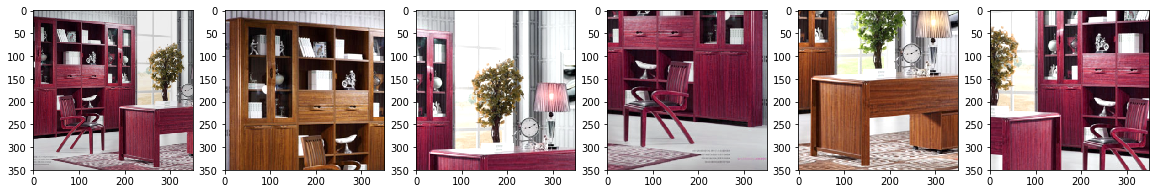

In [166]:
plt.figure(figsize=(20, 5))
for i in range(0, len(imgs)):
    plt.subplot(1, len(imgs), i + 1)
    plt.imshow(imgs[i])

augs with tensors

In [10]:
single_img_augs = Compose([
    RandomHorizontalFlip(p=0.5),
    ColorJitter(hue=0.12, brightness=0.12),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    
])

size = 224
augs_branch_1 = RandomResizedCrop(size, scale=(0.7, 1.0), interpolation=2)
augs_branch_2 = Compose([Resize(420, interpolation=2), FiveCrop(size=size)])


crops_train_augs = Compose([
    Lambda(lambda img: (augs_branch_1(img), ) + augs_branch_2(img)),
    Lambda(lambda crops: torch.stack([single_img_augs(crop) for crop in crops]))
])

img_augs_dataset = TransformedDataset(img_dataset, transforms=crops_train_augs)

In [11]:
from torch.utils.data import DataLoader

data_loader = DataLoader(img_augs_dataset, batch_size=10, num_workers=4)

In [12]:
data_loader_iter = iter(data_loader)

In [13]:
batchx, batchy = next(data_loader_iter)

In [14]:
batchx.shape, batchy.shape

(torch.Size([10, 6, 3, 224, 224]), torch.Size([10]))

Model on crops

In [33]:
from torch.nn import Module, Sequential, Conv2d, AdaptiveAvgPool2d, ReLU, Dropout, ModuleList, Linear
from torchvision.models.squeezenet import squeezenet1_1
from torch.nn.init import normal_, constant_


class FurnitureSqueezeNetOnCrops(Module):

    def __init__(self, pretrained=True, n_crops=6):
        super(FurnitureSqueezeNetOnCrops, self).__init__()
        model = squeezenet1_1(pretrained=pretrained)
        self.features = model.features
        self.crop_classifiers = []
        for i in range(n_crops):
            # Final convolution is initialized differently form the rest
            final_conv = Conv2d(512, 512, kernel_size=1, bias=False)
            self.crop_classifiers.append(Sequential(
                Dropout(p=0.5),
                final_conv,
                ReLU(inplace=True),
                AdaptiveAvgPool2d(1)
            ))
            for m in final_conv.modules():
                normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    constant_(m.bias, 0.0)            
        
        self.crop_classifiers = ModuleList(self.crop_classifiers)
        self.final_classifier = Linear(512, 128)
                
        for m in self.final_classifier.modules():
            normal_(m.weight, mean=0.0, std=0.01)
            if m.bias is not None:
                constant_(m.bias, 0.0)

    def forward(self, crops):        
        batch_size, n_crops, *_ = crops.shape
        features = []
        for i in range(n_crops):
            x = self.features(crops[:, i, :, :, :])
            x = self.crop_classifiers[i](x)
            features.append(x.view(batch_size, -1))
        x = sum(features)
        return self.final_classifier(x)

In [34]:
model = FurnitureSqueezeNetOnCrops(pretrained=False)

In [35]:
batchy_pred = model(batchx)

In [36]:
batchy_pred.shape

torch.Size([10, 128])

On crops with inception-resnetv2

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.insert(0, Path(".").absolute().parent.as_posix())

import numpy as np
from common.dataset import FilesFromCsvDataset, TrainvalFilesDataset, TransformedDataset, read_image, TestFilesDataset
from image_dataset_viz import render_datapoint, DatasetExporter

In [2]:
# Basic training configuration file
import torch
from torchvision.transforms import RandomHorizontalFlip, Compose, RandomResizedCrop
from torchvision.transforms import FiveCrop, Lambda, Resize
from torchvision.transforms import ColorJitter, ToTensor, Normalize
from common.dataset import FilesFromCsvDataset
from common.data_loaders import get_data_loader
from models.inceptionresnetv2 import FurnitureInceptionResNetOnCrops


SEED = 17
DEBUG = True
DEVICE = 'cuda'

size = 299

single_img_augs = Compose([
    RandomHorizontalFlip(p=0.5),
    ColorJitter(hue=0.12, brightness=0.12),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

augs_branch_1 = RandomResizedCrop(size, scale=(0.9, 1.0), interpolation=2)
augs_branch_2 = Compose([Resize(int(size * 1.5), interpolation=2), FiveCrop(size=size)])


TRAIN_TRANSFORMS = Compose([
    Lambda(lambda img: (augs_branch_1(img), ) + augs_branch_2(img)),
    Lambda(lambda crops: torch.stack([single_img_augs(crop) for crop in crops]))
])

VAL_TRANSFORMS = TRAIN_TRANSFORMS


BATCH_SIZE = 6
NUM_WORKERS = 15


dataset = FilesFromCsvDataset("../output/filtered_train_dataset.csv")
TRAIN_LOADER = get_data_loader(dataset,
                               data_transform=TRAIN_TRANSFORMS,
                               batch_size=BATCH_SIZE,
                               num_workers=NUM_WORKERS,
                               pin_memory='cuda' in DEVICE)


In [3]:
model = FurnitureInceptionResNetOnCrops(pretrained='imagenet', n_cls_layers=256).to(DEVICE)

In [6]:
loader_iter = iter(TRAIN_LOADER)

In [7]:
batch_x, batch_y = next(loader_iter)
batch_x = batch_x.to(DEVICE)
batch_y = batch_y.to(DEVICE)

In [8]:
batch_y_pred = model(batch_x)

Model with trainable zoom on a part

In [24]:
from torchvision.transforms import Compose, RandomVerticalFlip, RandomHorizontalFlip
from torchvision.transforms import Resize
from torchvision.transforms import ColorJitter, ToTensor, Normalize


size = 350
basic_train_augs = Compose([
    Resize((size, size), interpolation=3),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(hue=0.12, brightness=0.12),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
img_augs_dataset = TransformedDataset(img_dataset, transforms=basic_train_augs)

In [26]:
img, label = img_augs_dataset[0]

In [29]:
from torch.utils.data import DataLoader

data_loader = DataLoader(img_augs_dataset, batch_size=10, num_workers=4)

In [30]:
data_loader_iter = iter(data_loader)

In [50]:
batch_x, batch_y = next(data_loader_iter)

In [51]:
batch_x.shape, batch_y.shape

(torch.Size([10, 3, 350, 350]), torch.Size([10]))

In [57]:
import torch
from torch.nn import Module, Sequential, Conv2d, AdaptiveAvgPool2d, ReLU, Dropout, ModuleList, Linear
from torchvision.models.squeezenet import squeezenet1_1
from torch.nn.init import normal_, constant_


class FurnitureSqueezeNetWithZoom(Module):

    def __init__(self, pretrained=True):
        super(FurnitureSqueezeNetWithZoom, self).__init__()
        model = squeezenet1_1(pretrained=pretrained)
        self.features = model.features
                
        self.inner_classifiers = []
        for i in range(2):
            # Final convolution is initialized differently form the rest
            final_conv = Conv2d(512, 512, kernel_size=1, bias=False)
            self.inner_classifiers.append(Sequential(
                Dropout(p=0.5),
                final_conv,
                ReLU(inplace=True),
                AdaptiveAvgPool2d(1)
            ))
            for m in final_conv.modules():
                normal_(m.weight, mean=0.0, std=0.01)
                if m.bias is not None:
                    constant_(m.bias, 0.0)            
        
        self.inner_classifiers = ModuleList(self.inner_classifiers)
        self.final_classifier = Linear(512, 128)

        # Zoom params: center (x, y) and width/height normalized between [-0.5, 0.5]
        self.zoom_params = torch.tensor([0.0, 0.0, 1.0, 1.0], requires_grad=True)
        
        for m in self.final_classifier.modules():
            normal_(m.weight, mean=0.0, std=0.01)
            if m.bias is not None:
                constant_(m.bias, 0.0)
                
    def _zoom_on_data(self, x):
        _, _, h, w = x.shape
        ixs = int(self.zoom_params[0]) * w
        ixe = int(self.zoom_params[0] + self.zoom_params[2]) * w
        iys = int(self.zoom_params[1]) * h
        iye = int(self.zoom_params[1] + self.zoom_params[3]) * h
        out = x[:, :, iys:iye, ixs:ixe]
        return out
                
                
    def forward(self, x):
        batch_size, *_ = x.shape
        # zero-level classification:
        low_features = [
            self.features(x), 
            self.features(self._zoom_on_data(x))
        ]
        features = []
        for i, f in enumerate(low_features):
            x = self.inner_classifiers[i](f)
            features.append(x.view(batch_size, -1))
        x = sum(features)
        return self.final_classifier(x)

In [58]:
model = FurnitureSqueezeNetWithZoom(pretrained=False)

In [59]:
batch_y_pred = model(batchx)

In [60]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

loss = criterion(batch_y_pred, batch_y)

In [61]:
loss.backward()

In [62]:
model.zoom_params.grad

In [145]:
x = torch.tensor(list(range(100)))

w = torch.tensor([1.0, 0.0], requires_grad=True)
# ixs = (x[0]).long() * 100
# ixe = (x[0] + x[1]).long() * 100
# y = 30 - torch.sum(x[ixs:ixe])

In [151]:
ones = torch.ones_like(x)
x_hom = torch.cat([x.unsqueeze(-1), ones.unsqueeze(-1)], dim=1)

y = 30 - torch.sum(torch.sum(w * x_hom.float(), dim=-1))
y.backward()
y, w.grad

(tensor(-2.5004e+05), None)

In [147]:
w = w.sub(0.01 * w.grad)

In [127]:
ones = torch.ones_like(x)
x_hom = torch.cat([x.unsqueeze(-1), ones.unsqueeze(-1)], dim=1)

In [128]:
w * x_hom[2, :].float()

tensor([ 1.6000,  5.0000])

In [129]:
torch.sum(w * x_hom.float(), dim=-1)

tensor([  5.0000,   5.8000,   6.6000,   7.4000,   8.2000,   9.0000,
          9.8000,  10.6000,  11.4000,  12.2000,  13.0000,  13.8000,
         14.6000,  15.4000,  16.2000,  17.0000,  17.8000,  18.6000,
         19.4000,  20.2000,  21.0000,  21.8000,  22.6000,  23.4000,
         24.2000,  25.0000,  25.8000,  26.6000,  27.4000,  28.2000,
         29.0000,  29.8000,  30.6000,  31.4000,  32.2000,  33.0000,
         33.8000,  34.6000,  35.4000,  36.2000,  37.0000,  37.8000,
         38.6000,  39.4000,  40.2000,  41.0000,  41.8000,  42.6000,
         43.4000,  44.2000,  45.0000,  45.8000,  46.6000,  47.4000,
         48.2000,  49.0000,  49.8000,  50.6000,  51.4000,  52.2000,
         53.0000,  53.8000,  54.6000,  55.4000,  56.2000,  57.0000,
         57.8000,  58.6000,  59.4000,  60.2000,  61.0000,  61.8000,
         62.6000,  63.4000,  64.2000,  65.0000,  65.8000,  66.6000,
         67.4000,  68.2000,  69.0000,  69.8000,  70.6000,  71.4000,
         72.2000,  73.0000,  73.8000,  74.6000, 

In [82]:
from torchviz import make_dot

In [83]:
make_dot(y)

In [68]:
x.grad

tensor([ 0.,  2.,  4.,  6.])

In [63]:
from torch.nn import functional as F

In [ ]:
F.cro

In [84]:
x[ixs:ixe]

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,
         24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
         36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  98,  99])

In [2]:
70 * 272 / 3600

5.288888888888889